# Benchmark Modell MPA

## 1. Import Libraries und Daten

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#Import data
df_mpa = pd.read_csv("../data/data_mpa.txt", sep=" ")
df_spg = pd.read_csv("../data/data_spg.txt", sep=" ")
df_sps = pd.read_csv("../data/data_sps.txt", sep=" ")

## 2. Filter Attributes

Für das einfache Modell werden wir nur die Features nehmen, die auch stark mit der korngrösse Korrelieren. Dafür werden wir Rangkorrelation nach Spearman anwenden.

In [3]:
tmp = df_mpa.corr(method='spearman')['size_mm']
tmp = tmp[~tmp.index.isin(['size_mm'])]
tmp = tmp.abs().sort_values(ascending=False)
tmp.head(5)

centroid_frequency_M04     0.772877
centroid_frequency2_M04    0.764935
centroid_frequency_M02     0.756375
median_freq_M04            0.754218
centroid_frequency_M01     0.751949
Name: size_mm, dtype: float64

Die Attribute "centroid frequency" haben die stärkste Korrelation. Aus diesem Grund nehmen wir nur diese Attribute für den Benchmark.

In [4]:
filter_col = [col for col in df_mpa if col.startswith('centroid_frequency')]
filter_col.append("size_mm")
df_mpa = df_mpa[filter_col]

In [5]:
df_mpa.shape

(21663, 9)

Der neue Datensatz hat jetzt nur noch 9 Attribute (inklusiv die Zielvariable).

## 3. Transformation

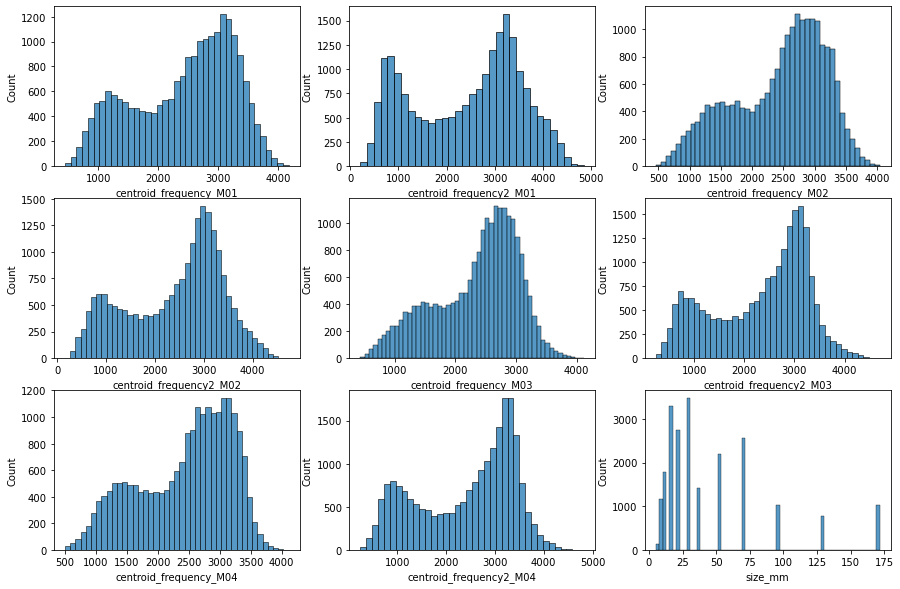

In [6]:
fig = plt.subplots(figsize=(15, 10))

for k in range(df_mpa.shape[1]):
    plt.subplot(3,3,k+1)
    sns.histplot(df_mpa.iloc[:, k])
    
plt.show()

Zurzeit haben wir überall eine bimodale Verteilung der Daten ausser bei der Zielvaribale (size_mm).
Die Zielvariable hat eine rechtsschiefe Verteilung. Für eine normalere Verteilung würden wir diese Variable logarithmieren.

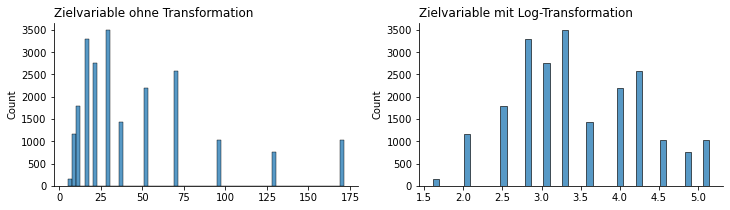

In [7]:
fig = plt.subplots(1, 2, figsize=(12, 3))
tmp = df_mpa['size_mm'].to_numpy()
plt.subplot(1,2,1)
p = sns.histplot(tmp)
p.set_title('Zielvariable ohne Transformation', loc='left')
plt.subplot(1,2,2)
p = sns.histplot(np.log(tmp))
p.set_title('Zielvariable mit Log-Transformation', loc='left')
sns.despine()
plt.show()

Der Plot zeigt, dass durch die empfohlene Transformation die Korngrösse normalverteilter gemacht wird. Durch die Transformation könnte durchaus eine Verbesserung des Modells erreicht werden.

## 4. Benchmark Lineares Modell

In [8]:
df_mpa = df_mpa.sample(frac = 1).reset_index(drop = True)

In [9]:
X, y = df_mpa.drop(['size_mm'], axis=1), np.log(df_mpa['size_mm'])

In [10]:
model = LinearRegression()
model.fit(X,y)
cvs = cross_val_score(model, X, y, cv=5)
np.mean(cvs)

0.7147273602832541

Mit nur 8 Attributen und logarithmieren der Zielvariable konnten wir bereits einen R2 Score von über 70% erreichen. Dieser Wert wird allgemein bereits als gut angesehen. Dies nehmen wir als Benchmark für unsere MPA-Modelle.

#### 4.1 Residuenanalyse

In [19]:
y_pred = model.predict(X)
res = y_pred-y
np.mean(res)

5.084793777925935e-16

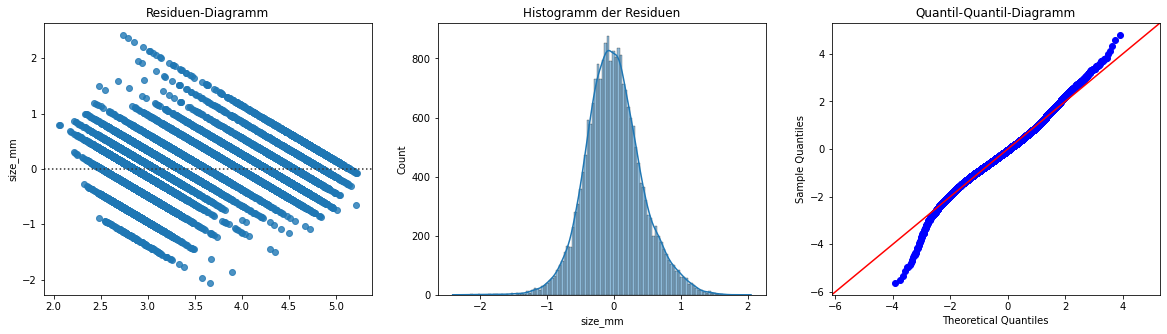

In [18]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))

sns.residplot(x=y_pred,y=y,ax=ax[0])
ax[0].title.set_text("Residuen-Diagramm")

sns.histplot(res,kde=True,ax=ax[1])
ax[1].title.set_text("Histogramm der Residuen")

sm.qqplot(res, fit=True, line="45", ax=ax[2])
ax[2].title.set_text("Quantil-Quantil-Diagramm")
plt.show()

Interpretation:
- die Residuen haben den Erwartungwert um 0 herum
- eine Normalverteilung der Residuen ist ebenfalls vorhanden
- ein leicht systematischer Fehler erkennbar